<h1>Experiments with feature detection algorithms</h1>

The goal is to test / develop algorithms for automated spectral line detection. These will eventually make their way into a specviz plug-in.

(from ticket #304):

The simplest useful detection algorithm is the following:

 - Convolve the spectrum with a fixed kernel (usually a Gaussian with FWHM corresponding to the spectral resolution).
 - Divide by the RMS noise and search for pixels above or below a fixed S/N threshold. These are the emission or absorption line centers.


In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\AA$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
SIZE = (16, 3)
xmin = 1130.
xmax = 1480.
zero_line = [(xmin, xmax),(0.,0.)]

<h3>Get raw data</h3>

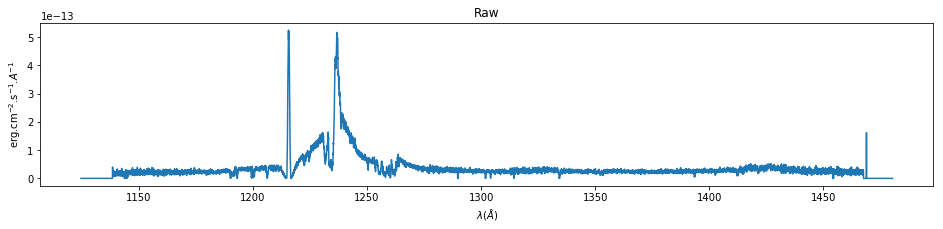

In [2]:
hdulist = fits.open('data/combined_13330_G130M_v40_bin4.fits')
flux = hdulist[1].data['flux'][0]
wave = hdulist[1].data['wavelength'][0]

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Raw')

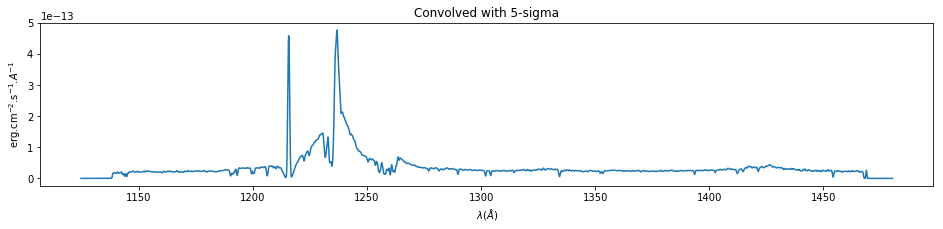

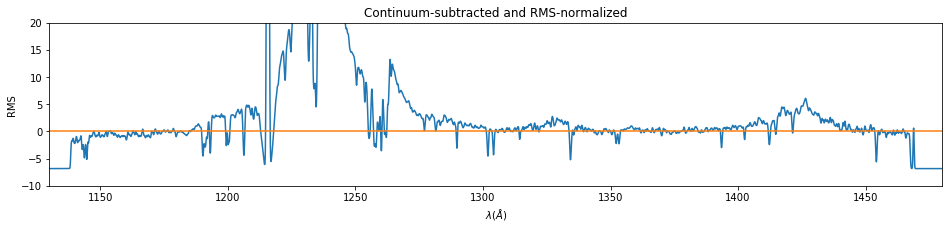

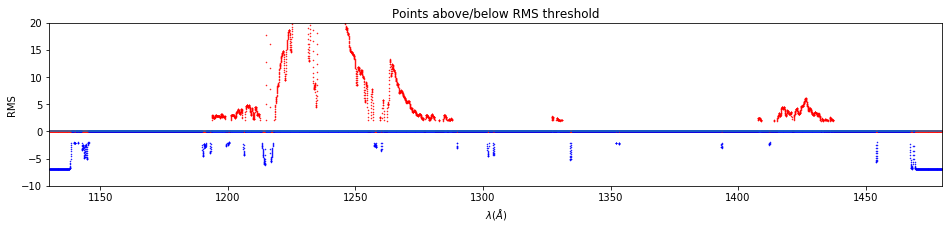

In [3]:
# Convolution
#
STDDEV = 5

from astropy.convolution import convolve, Gaussian1DKernel
gauss = Gaussian1DKernel(stddev=STDDEV)
convolved_flux = convolve(flux, gauss)

plt.figure(figsize=SIZE)
plt.plot(wave, convolved_flux)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Convolved with ' + str(STDDEV) + '-sigma')

# Normalize by RMS noise.
# 
# Do the dumb thing and pick a region by eye. 
# A real-world implementation should do better 
# than that.
indices = (wave > 1360.) & (wave < 1380.) 
f1 = flux[indices]
mean = np.median(f1) # median is less affected by outliers
rms = np.std(f1)

normalized_flux = (convolved_flux - mean) / rms

plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux)
plt.plot(zero_line[0], zero_line[1])
plt.axis([xmin, xmax, -10., 20.])
plt.xlabel(x_label)
plt.ylabel('RMS')
plt.title('Continuum-subtracted and RMS-normalized')

# Search for points above and below a threshold.
threshold = 2.

out = np.where(normalized_flux < threshold)
normalized_flux[out] = 0.

normalized_flux_2 = (convolved_flux - mean) / rms
out = np.where(normalized_flux_2 > -threshold)
normalized_flux_2[out] = 0.

plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux, '.', color='r', markersize=1)
plt.plot(wave, normalized_flux_2, '.', color='b', markersize=1)
plt.plot(zero_line[0], zero_line[1])
plt.axis([xmin, xmax, -10., 20.])
plt.xlabel(x_label)
plt.ylabel('RMS')
plt.title('Points above/below RMS threshold')

A better algorithm may be one that looks for the first derivative zero crossings. That way, slow fluctuations along the spectrum are cancelled out and the detection becomes local. 

We will give a shot at this one: https://terpconnect.umd.edu/~toh/spectrum/PeakFindingandMeasurement.htm 

with Matlab code in here: https://terpconnect.umd.edu/~toh/spectrum/findpeaksx.m

<h3>First derivative zero-crossings</h3>

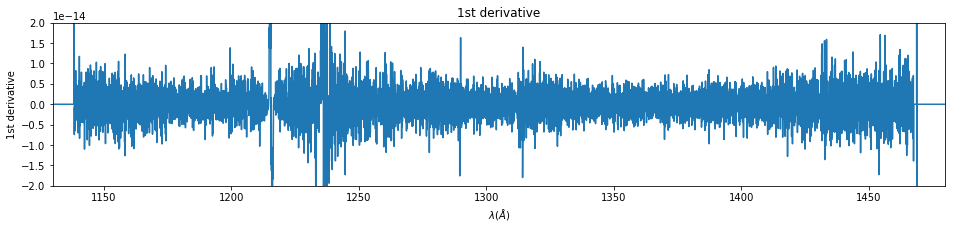

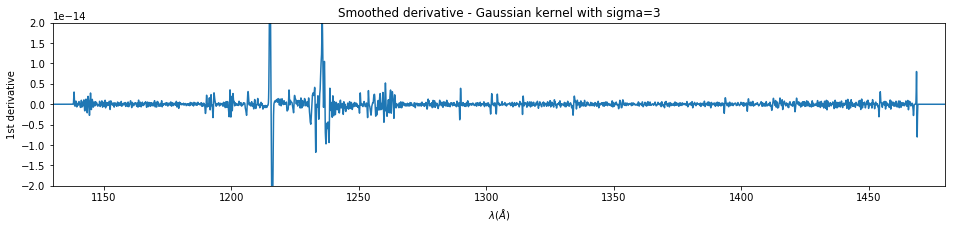

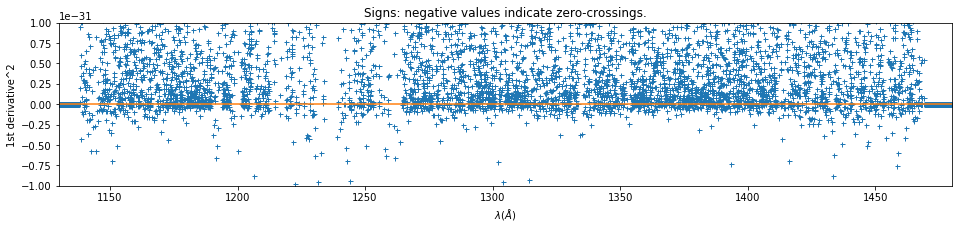

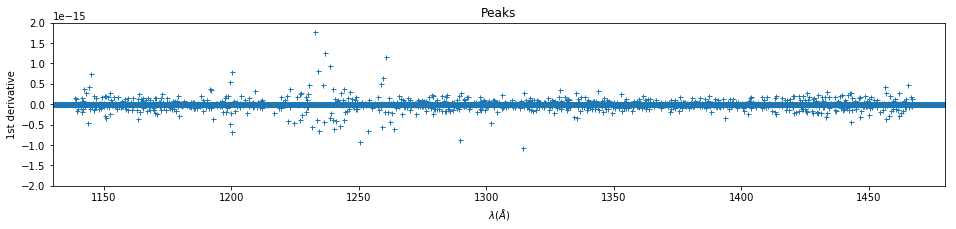

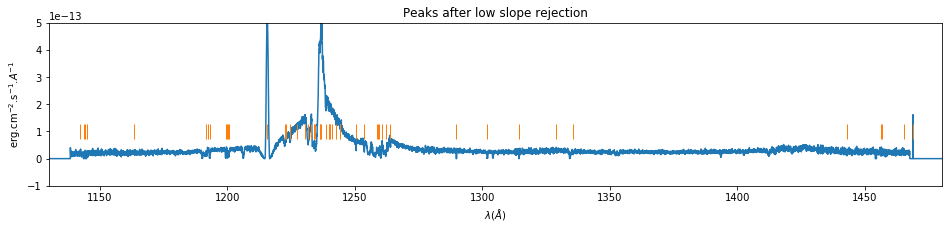

In [4]:
# 1st derivative
deriv = np.gradient(flux)

plt.figure(figsize=SIZE)
plt.plot(wave, deriv)
plt.axis([xmin, xmax, -2.e-14, 2.e-14])
plt.xlabel(x_label)
plt.ylabel('1st derivative')
plt.title('1st derivative')

# smooth it - gaussian stddev is a free parameter
STDDEV = 3
gauss = Gaussian1DKernel(stddev=STDDEV)
smooth_deriv = convolve(deriv, gauss)

plt.figure(figsize=SIZE)
plt.plot(wave, smooth_deriv)
plt.axis([xmin, xmax, -2.e-14, 2.e-14])
plt.xlabel(x_label)
plt.ylabel('1st derivative')
plt.title('Smoothed derivative - Gaussian kernel with sigma=' + str(STDDEV))

# detect zero crossings
# first, we locate where the derivative changes sign.
signs = smooth_deriv[:-1] * smooth_deriv[1:]

plt.figure(figsize=SIZE)
plt.plot(wave[1:], signs, '+', markersize=5)
plt.plot(zero_line[0], zero_line[1])
plt.axis([xmin, xmax, -1.e-31, 1.e-31])
plt.xlabel(x_label)
plt.ylabel('1st derivative^2')
plt.title('Signs: negative values indicate zero-crossings.')

# peaks are located at the zero-crossings
crossings = np.where(signs <= 0)
non_crossings = np.where(signs > 0)

peaks = smooth_deriv.copy()
peaks[non_crossings] = 0.

plt.figure(figsize=SIZE)
plt.plot(wave, peaks, '+', markersize=5)
plt.axis([xmin, xmax, -2.e-15, 2.e-15])
plt.xlabel(x_label)
plt.ylabel('1st derivative')
plt.title('Peaks')

# slope threshold - free parameter. 
# we arbitrarily pick as theshold 10% of the 
# maximum slope found in the smoothed derivatives.
SLOPE_THRESHOLD = 0.1

max_slope = np.max(smooth_deriv[crossings])
reject = np.where(np.abs(peaks) < max_slope * SLOPE_THRESHOLD)
peaks[reject] = 0.

# create markers and plot them
markers = np.full(peaks.shape, -100.)
markers[np.where(np.abs(peaks) > 0.)] = 1.e-13

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=15)
plt.axis([xmin, xmax, -1.e-13, 5.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Peaks after low slope rejection')

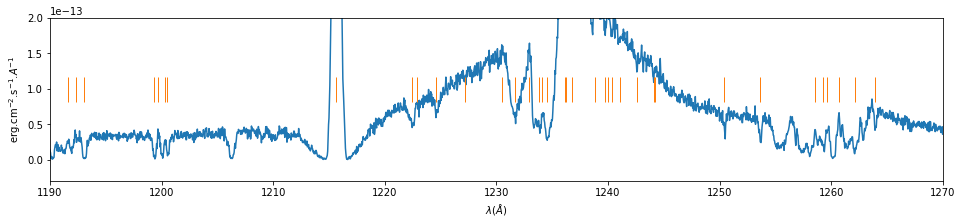

In [5]:
plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.plot(wave, markers, '|', markersize=25)
plt.axis([1190., 1270., -0.3e-13, 2.e-13])
plt.xlabel(x_label)
plt.ylabel(y_label)